# Analysis of the Sensitivity with respect to Spectrum Truncation

## Preamble

In [20]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

normalize_features = False
normalize_labels = True

### Noise

In [3]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

noise_sampled_y = 0.01
noisy_y = sampled_y + noise_sampled_y * torch.randn(m)

### Normalize

In [4]:
if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = noisy_y.mean(), noisy_y.std()
    noisy_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [5]:
noisy_x, noisy_y = noisy_x.contiguous(), noisy_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x, noisy_y = noisy_x.to(device), noisy_y.to(device)

## Model

In [6]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=2,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=100,
        ball_scale=3.0,
        prior_bandwidth=False,
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(noisy_x, noisy_y, likelihood, kernel).to(device)

## Train

In [7]:
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

model.manifold_informed_train(lr=1e-2, iter=100, 
                              decay_step_size=1000, decay_magnitude=1.0,
                              norm_step_size=10, norm_rand_vec=100, 
                              verbose=True, save=False)

Iter: 0, LR: 0.010, Loss: 152.001, NoiseVar: 0.010, SignalVar: 5.595, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, LR: 0.010, Loss: 137.135, NoiseVar: 0.010, SignalVar: 5.585, Lengthscale: 0.994, Epsilon: 0.496
Iter: 2, LR: 0.010, Loss: 121.950, NoiseVar: 0.010, SignalVar: 5.575, Lengthscale: 0.987, Epsilon: 0.492
Iter: 3, LR: 0.010, Loss: 96.021, NoiseVar: 0.010, SignalVar: 5.565, Lengthscale: 0.981, Epsilon: 0.488
Iter: 4, LR: 0.010, Loss: 94.084, NoiseVar: 0.010, SignalVar: 5.555, Lengthscale: 0.975, Epsilon: 0.484
Iter: 5, LR: 0.010, Loss: 71.136, NoiseVar: 0.010, SignalVar: 5.545, Lengthscale: 0.969, Epsilon: 0.481
Iter: 6, LR: 0.010, Loss: 51.998, NoiseVar: 0.009, SignalVar: 5.535, Lengthscale: 0.963, Epsilon: 0.477
Iter: 7, LR: 0.010, Loss: 38.728, NoiseVar: 0.009, SignalVar: 5.525, Lengthscale: 0.957, Epsilon: 0.473
Iter: 8, LR: 0.010, Loss: 23.132, NoiseVar: 0.009, SignalVar: 5.516, Lengthscale: 0.951, Epsilon: 0.469
Iter: 9, LR: 0.010, Loss: 3.861, NoiseVar: 0.009, SignalVar: 

Iter: 88, LR: 0.010, Loss: -1612.792, NoiseVar: 0.004, SignalVar: 4.711, Lengthscale: 1.086, Epsilon: 0.219
Iter: 89, LR: 0.010, Loss: -1654.103, NoiseVar: 0.003, SignalVar: 4.699, Lengthscale: 1.091, Epsilon: 0.216
Iter: 90, LR: 0.010, Loss: -1694.855, NoiseVar: 0.003, SignalVar: 4.687, Lengthscale: 1.096, Epsilon: 0.214
Iter: 91, LR: 0.010, Loss: -1706.152, NoiseVar: 0.003, SignalVar: 4.674, Lengthscale: 1.101, Epsilon: 0.212
Iter: 92, LR: 0.010, Loss: -1751.296, NoiseVar: 0.003, SignalVar: 4.662, Lengthscale: 1.106, Epsilon: 0.209
Iter: 93, LR: 0.010, Loss: -1779.824, NoiseVar: 0.003, SignalVar: 4.650, Lengthscale: 1.111, Epsilon: 0.207
Iter: 94, LR: 0.010, Loss: -1820.901, NoiseVar: 0.003, SignalVar: 4.638, Lengthscale: 1.116, Epsilon: 0.204
Iter: 95, LR: 0.010, Loss: -1831.682, NoiseVar: 0.003, SignalVar: 4.625, Lengthscale: 1.121, Epsilon: 0.202
Iter: 96, LR: 0.010, Loss: -1868.710, NoiseVar: 0.003, SignalVar: 4.613, Lengthscale: 1.126, Epsilon: 0.200
Iter: 97, LR: 0.010, Loss: -

In [8]:
log_rmse_100 = []
log_nll_100 = []
for i in range(1,m,50):
    kernel.base_kernel.modes = i
    likelihood.eval()
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood(model(noisy_x))
        error = noisy_y - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        log_rmse_100.append((error.square().sum()/noisy_y.shape[0]).sqrt().cpu())
        log_nll_100.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/noisy_y.shape[0]).cpu())
        model._clear_cache()

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [9]:
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

model.manifold_informed_train(lr=1e-2, iter=200, 
                              decay_step_size=1000, decay_magnitude=1.0,
                              norm_step_size=10, norm_rand_vec=100, 
                              verbose=True, save=False)

Iter: 0, LR: 0.010, Loss: 147.549, NoiseVar: 0.010, SignalVar: 5.595, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, LR: 0.010, Loss: 133.674, NoiseVar: 0.010, SignalVar: 5.585, Lengthscale: 0.994, Epsilon: 0.496
Iter: 2, LR: 0.010, Loss: 119.622, NoiseVar: 0.010, SignalVar: 5.575, Lengthscale: 0.987, Epsilon: 0.492
Iter: 3, LR: 0.010, Loss: 101.009, NoiseVar: 0.010, SignalVar: 5.565, Lengthscale: 0.981, Epsilon: 0.488
Iter: 4, LR: 0.010, Loss: 84.855, NoiseVar: 0.010, SignalVar: 5.555, Lengthscale: 0.975, Epsilon: 0.484
Iter: 5, LR: 0.010, Loss: 70.782, NoiseVar: 0.010, SignalVar: 5.545, Lengthscale: 0.969, Epsilon: 0.481
Iter: 6, LR: 0.010, Loss: 52.964, NoiseVar: 0.009, SignalVar: 5.535, Lengthscale: 0.963, Epsilon: 0.477
Iter: 7, LR: 0.010, Loss: 37.741, NoiseVar: 0.009, SignalVar: 5.526, Lengthscale: 0.957, Epsilon: 0.473
Iter: 8, LR: 0.010, Loss: 15.026, NoiseVar: 0.009, SignalVar: 5.516, Lengthscale: 0.951, Epsilon: 0.469
Iter: 9, LR: 0.010, Loss: 3.923, NoiseVar: 0.009, SignalVar:

Iter: 78, LR: 0.010, Loss: -1332.751, NoiseVar: 0.004, SignalVar: 4.828, Lengthscale: 1.041, Epsilon: 0.245
Iter: 79, LR: 0.010, Loss: -1357.999, NoiseVar: 0.004, SignalVar: 4.817, Lengthscale: 1.046, Epsilon: 0.242
Iter: 80, LR: 0.010, Loss: -1399.239, NoiseVar: 0.004, SignalVar: 4.805, Lengthscale: 1.050, Epsilon: 0.239
Iter: 81, LR: 0.010, Loss: -1408.328, NoiseVar: 0.004, SignalVar: 4.793, Lengthscale: 1.055, Epsilon: 0.237
Iter: 82, LR: 0.010, Loss: -1448.413, NoiseVar: 0.004, SignalVar: 4.781, Lengthscale: 1.059, Epsilon: 0.234
Iter: 83, LR: 0.010, Loss: -1477.112, NoiseVar: 0.004, SignalVar: 4.769, Lengthscale: 1.064, Epsilon: 0.231
Iter: 84, LR: 0.010, Loss: -1486.482, NoiseVar: 0.004, SignalVar: 4.757, Lengthscale: 1.069, Epsilon: 0.229
Iter: 85, LR: 0.010, Loss: -1532.852, NoiseVar: 0.004, SignalVar: 4.745, Lengthscale: 1.073, Epsilon: 0.226
Iter: 86, LR: 0.010, Loss: -1561.086, NoiseVar: 0.004, SignalVar: 4.733, Lengthscale: 1.078, Epsilon: 0.224
Iter: 87, LR: 0.010, Loss: -

Iter: 167, LR: 0.010, Loss: -4322.520, NoiseVar: 0.001, SignalVar: 3.705, Lengthscale: 1.498, Epsilon: 0.087
Iter: 168, LR: 0.010, Loss: -4356.857, NoiseVar: 0.001, SignalVar: 3.692, Lengthscale: 1.503, Epsilon: 0.086
Iter: 169, LR: 0.010, Loss: -4436.814, NoiseVar: 0.001, SignalVar: 3.677, Lengthscale: 1.508, Epsilon: 0.085
Iter: 170, LR: 0.010, Loss: -4464.599, NoiseVar: 0.001, SignalVar: 3.663, Lengthscale: 1.513, Epsilon: 0.084
Iter: 171, LR: 0.010, Loss: -4500.792, NoiseVar: 0.001, SignalVar: 3.649, Lengthscale: 1.518, Epsilon: 0.082
Iter: 172, LR: 0.010, Loss: -4568.597, NoiseVar: 0.001, SignalVar: 3.634, Lengthscale: 1.523, Epsilon: 0.081
Iter: 173, LR: 0.010, Loss: -4663.765, NoiseVar: 0.001, SignalVar: 3.618, Lengthscale: 1.528, Epsilon: 0.080
Iter: 174, LR: 0.010, Loss: -4718.027, NoiseVar: 0.001, SignalVar: 3.603, Lengthscale: 1.533, Epsilon: 0.079
Iter: 175, LR: 0.010, Loss: -4804.338, NoiseVar: 0.001, SignalVar: 3.586, Lengthscale: 1.538, Epsilon: 0.078
Iter: 176, LR: 0.01

In [10]:
log_rmse_200 = []
log_nll_200 = []
for i in range(1,m,50):
    kernel.base_kernel.modes = i
    likelihood.eval()
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood(model(noisy_x))
        error = noisy_y - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        log_rmse_200.append((error.square().sum()/noisy_y.shape[0]).sqrt().cpu())
        log_nll_200.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/noisy_y.shape[0]).cpu())
        model._clear_cache()

In [11]:
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

model.manifold_informed_train(lr=1e-2, iter=1000, 
                              decay_step_size=500, decay_magnitude=0.1,
                              norm_step_size=10, norm_rand_vec=100, 
                              verbose=True, save=False)

Iter: 0, LR: 0.010, Loss: 157.526, NoiseVar: 0.010, SignalVar: 5.595, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, LR: 0.010, Loss: 132.272, NoiseVar: 0.010, SignalVar: 5.585, Lengthscale: 0.994, Epsilon: 0.496
Iter: 2, LR: 0.010, Loss: 115.281, NoiseVar: 0.010, SignalVar: 5.575, Lengthscale: 0.987, Epsilon: 0.492
Iter: 3, LR: 0.010, Loss: 103.908, NoiseVar: 0.010, SignalVar: 5.565, Lengthscale: 0.981, Epsilon: 0.488
Iter: 4, LR: 0.010, Loss: 89.334, NoiseVar: 0.010, SignalVar: 5.555, Lengthscale: 0.975, Epsilon: 0.484
Iter: 5, LR: 0.010, Loss: 63.565, NoiseVar: 0.010, SignalVar: 5.545, Lengthscale: 0.969, Epsilon: 0.481
Iter: 6, LR: 0.010, Loss: 52.454, NoiseVar: 0.009, SignalVar: 5.535, Lengthscale: 0.963, Epsilon: 0.477
Iter: 7, LR: 0.010, Loss: 34.328, NoiseVar: 0.009, SignalVar: 5.526, Lengthscale: 0.957, Epsilon: 0.473
Iter: 8, LR: 0.010, Loss: 18.606, NoiseVar: 0.009, SignalVar: 5.516, Lengthscale: 0.951, Epsilon: 0.469
Iter: 9, LR: 0.010, Loss: 7.779, NoiseVar: 0.009, SignalVar:

Iter: 89, LR: 0.010, Loss: -1677.886, NoiseVar: 0.003, SignalVar: 4.694, Lengthscale: 1.093, Epsilon: 0.216
Iter: 90, LR: 0.010, Loss: -1686.267, NoiseVar: 0.003, SignalVar: 4.682, Lengthscale: 1.098, Epsilon: 0.214
Iter: 91, LR: 0.010, Loss: -1728.090, NoiseVar: 0.003, SignalVar: 4.669, Lengthscale: 1.103, Epsilon: 0.211
Iter: 92, LR: 0.010, Loss: -1749.461, NoiseVar: 0.003, SignalVar: 4.657, Lengthscale: 1.108, Epsilon: 0.209
Iter: 93, LR: 0.010, Loss: -1791.066, NoiseVar: 0.003, SignalVar: 4.645, Lengthscale: 1.113, Epsilon: 0.206
Iter: 94, LR: 0.010, Loss: -1819.977, NoiseVar: 0.003, SignalVar: 4.632, Lengthscale: 1.118, Epsilon: 0.204
Iter: 95, LR: 0.010, Loss: -1834.708, NoiseVar: 0.003, SignalVar: 4.620, Lengthscale: 1.123, Epsilon: 0.202
Iter: 96, LR: 0.010, Loss: -1886.633, NoiseVar: 0.003, SignalVar: 4.608, Lengthscale: 1.128, Epsilon: 0.199
Iter: 97, LR: 0.010, Loss: -1926.015, NoiseVar: 0.003, SignalVar: 4.595, Lengthscale: 1.133, Epsilon: 0.197
Iter: 98, LR: 0.010, Loss: -

Iter: 177, LR: 0.010, Loss: -5003.327, NoiseVar: 0.001, SignalVar: 3.550, Lengthscale: 1.552, Epsilon: 0.076
Iter: 178, LR: 0.010, Loss: -5108.401, NoiseVar: 0.001, SignalVar: 3.532, Lengthscale: 1.557, Epsilon: 0.074
Iter: 179, LR: 0.010, Loss: -5227.223, NoiseVar: 0.001, SignalVar: 3.514, Lengthscale: 1.562, Epsilon: 0.073
Iter: 180, LR: 0.010, Loss: -5396.339, NoiseVar: 0.001, SignalVar: 3.494, Lengthscale: 1.567, Epsilon: 0.072
Iter: 181, LR: 0.010, Loss: -5555.893, NoiseVar: 0.001, SignalVar: 3.475, Lengthscale: 1.572, Epsilon: 0.071
Iter: 182, LR: 0.010, Loss: -5676.941, NoiseVar: 0.001, SignalVar: 3.455, Lengthscale: 1.577, Epsilon: 0.069
Iter: 183, LR: 0.010, Loss: -5849.562, NoiseVar: 0.001, SignalVar: 3.434, Lengthscale: 1.581, Epsilon: 0.068
Iter: 184, LR: 0.010, Loss: -5986.825, NoiseVar: 0.001, SignalVar: 3.413, Lengthscale: 1.586, Epsilon: 0.067
Iter: 185, LR: 0.010, Loss: -6132.320, NoiseVar: 0.001, SignalVar: 3.392, Lengthscale: 1.591, Epsilon: 0.066
Iter: 186, LR: 0.01

Iter: 253, LR: 0.010, Loss: -6403.223, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 1.869, Epsilon: 0.061
Iter: 254, LR: 0.010, Loss: -6382.601, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 1.872, Epsilon: 0.061
Iter: 255, LR: 0.010, Loss: -6369.654, NoiseVar: 0.001, SignalVar: 3.356, Lengthscale: 1.875, Epsilon: 0.061
Iter: 256, LR: 0.010, Loss: -6368.833, NoiseVar: 0.001, SignalVar: 3.356, Lengthscale: 1.878, Epsilon: 0.061
Iter: 257, LR: 0.010, Loss: -6358.375, NoiseVar: 0.001, SignalVar: 3.357, Lengthscale: 1.881, Epsilon: 0.061
Iter: 258, LR: 0.010, Loss: -6398.271, NoiseVar: 0.001, SignalVar: 3.358, Lengthscale: 1.884, Epsilon: 0.061
Iter: 259, LR: 0.010, Loss: -6377.223, NoiseVar: 0.001, SignalVar: 3.358, Lengthscale: 1.886, Epsilon: 0.061
Iter: 260, LR: 0.010, Loss: -6402.646, NoiseVar: 0.001, SignalVar: 3.358, Lengthscale: 1.889, Epsilon: 0.061
Iter: 261, LR: 0.010, Loss: -6403.959, NoiseVar: 0.001, SignalVar: 3.359, Lengthscale: 1.892, Epsilon: 0.061
Iter: 262, LR: 0.01

Iter: 329, LR: 0.010, Loss: -6397.161, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.050, Epsilon: 0.060
Iter: 330, LR: 0.010, Loss: -6378.451, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.051, Epsilon: 0.060
Iter: 331, LR: 0.010, Loss: -6376.505, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.053, Epsilon: 0.060
Iter: 332, LR: 0.010, Loss: -6403.738, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.055, Epsilon: 0.060
Iter: 333, LR: 0.010, Loss: -6379.983, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.057, Epsilon: 0.060
Iter: 334, LR: 0.010, Loss: -6411.635, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.059, Epsilon: 0.060
Iter: 335, LR: 0.010, Loss: -6398.107, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.061, Epsilon: 0.060
Iter: 336, LR: 0.010, Loss: -6415.818, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.063, Epsilon: 0.060
Iter: 337, LR: 0.010, Loss: -6418.696, NoiseVar: 0.001, SignalVar: 3.360, Lengthscale: 2.065, Epsilon: 0.060
Iter: 338, LR: 0.01

Iter: 405, LR: 0.010, Loss: -6393.900, NoiseVar: 0.001, SignalVar: 3.354, Lengthscale: 2.181, Epsilon: 0.058
Iter: 406, LR: 0.010, Loss: -6417.312, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 2.182, Epsilon: 0.058
Iter: 407, LR: 0.010, Loss: -6398.085, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 2.184, Epsilon: 0.058
Iter: 408, LR: 0.010, Loss: -6410.878, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 2.185, Epsilon: 0.058
Iter: 409, LR: 0.010, Loss: -6434.556, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 2.186, Epsilon: 0.058
Iter: 410, LR: 0.010, Loss: -6422.435, NoiseVar: 0.001, SignalVar: 3.355, Lengthscale: 2.188, Epsilon: 0.058
Iter: 411, LR: 0.010, Loss: -6412.444, NoiseVar: 0.001, SignalVar: 3.354, Lengthscale: 2.189, Epsilon: 0.058
Iter: 412, LR: 0.010, Loss: -6401.898, NoiseVar: 0.001, SignalVar: 3.354, Lengthscale: 2.191, Epsilon: 0.058
Iter: 413, LR: 0.010, Loss: -6409.504, NoiseVar: 0.001, SignalVar: 3.354, Lengthscale: 2.192, Epsilon: 0.058
Iter: 414, LR: 0.01

Iter: 481, LR: 0.010, Loss: -6426.445, NoiseVar: 0.001, SignalVar: 3.343, Lengthscale: 2.285, Epsilon: 0.057
Iter: 482, LR: 0.010, Loss: -6398.953, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.286, Epsilon: 0.057
Iter: 483, LR: 0.010, Loss: -6422.521, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.287, Epsilon: 0.057
Iter: 484, LR: 0.010, Loss: -6429.183, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.289, Epsilon: 0.057
Iter: 485, LR: 0.010, Loss: -6412.414, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.290, Epsilon: 0.057
Iter: 486, LR: 0.010, Loss: -6433.667, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.291, Epsilon: 0.057
Iter: 487, LR: 0.010, Loss: -6432.544, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.292, Epsilon: 0.057
Iter: 488, LR: 0.010, Loss: -6440.588, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.294, Epsilon: 0.057
Iter: 489, LR: 0.010, Loss: -6401.630, NoiseVar: 0.001, SignalVar: 3.342, Lengthscale: 2.295, Epsilon: 0.057
Iter: 490, LR: 0.01

In [12]:
log_rmse_500 = []
log_nll_500 = []
for i in range(1,m,50):
    kernel.base_kernel.modes = i
    likelihood.eval()
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood(model(noisy_x))
        error = noisy_y - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        log_rmse_500.append((error.square().sum()/noisy_y.shape[0]).sqrt().cpu())
        log_nll_500.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/noisy_y.shape[0]).cpu())
        model._clear_cache()

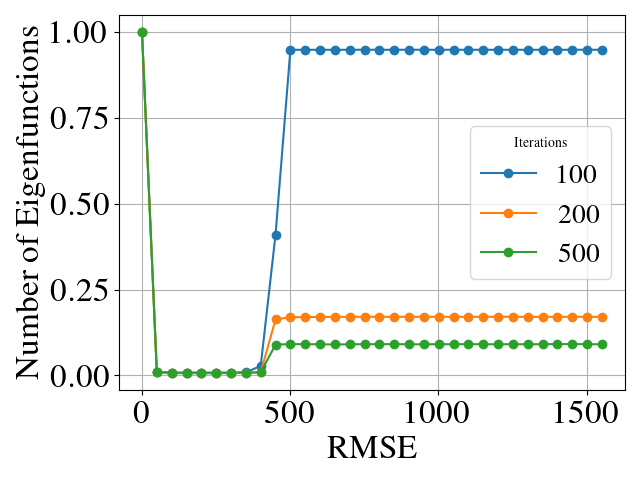

In [23]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

# Create figure and axes
fig, ax = plt.subplots()

# Data
x = np.arange(1, m, 50)
y1 = np.array(log_rmse_100)
y2 = np.array(log_rmse_200)
y3 = np.array(log_rmse_500)

# Plot lines with markers
ax.plot(x, y1, '-o', label='100')
ax.plot(x, y2, '-o', label='200')
ax.plot(x, y3, '-o', label='500')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of Eigenfunctions', fontsize=24)
ax.set_ylabel('RMSE', fontsize=24)

# Set title
# ax.set_title('RMSE Values')

# Set legend
ax.legend(title='Iterations', fontsize=20)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Set grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

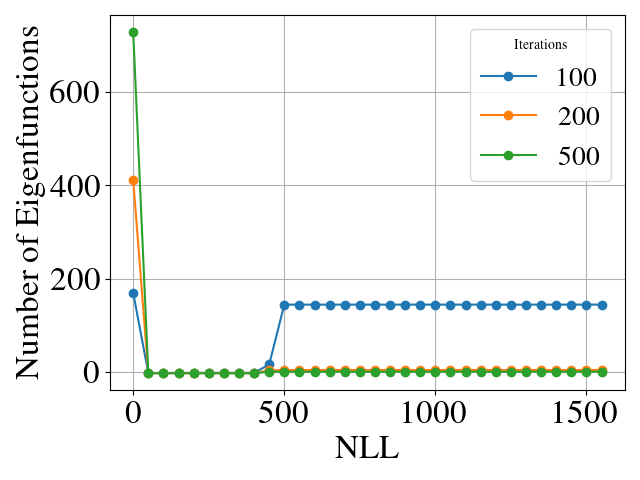

In [24]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

# Create figure and axes
fig, ax = plt.subplots()

# Data
x = np.arange(1, m, 50)
y1 = np.array(log_nll_100)
y2 = np.array(log_nll_200)
y3 = np.array(log_nll_500)

# Plot lines with markers
ax.plot(x, y1, '-o', label='100')
ax.plot(x, y2, '-o', label='200')
ax.plot(x, y3, '-o', label='500')

# Set x-axis and y-axis labels
ax.set_xlabel('Number of Eigenfunctions', fontsize=24)
ax.set_ylabel('NLL', fontsize=24)

# # Set title
# ax.set_title('NLL Values')

# Set legend
ax.legend(title='Iterations', fontsize=20)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Set grid
ax.grid(True)

# Adjust layout
fig.tight_layout()